# **EduSense: Multi-Task Ordinal Classification with CORAL**

**King Khalid University - Graduation Project 2025**

---

## Stage B: Training & Inference (CORAL Ordinal Classification)

```
Load .npy embeddings → LSTM → KAN → 4 Ordinal Heads → Emotion Predictions (0-3)
```

**Architecture:**
- ✅ Pre-extracted embeddings (Stage A completed)
- ✅ Multi-task learning (4 emotions: Engagement, Boredom, Confusion, Frustration)
- ✅ CORAL ordinal classification (respects ordered labels)
- ✅ Production-ready PyTorch code

### debugging


In [38]:
# RERUN 
import json
from pathlib import Path
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# ============================================================
# 1. RELOAD THE UPDATED METADATA
# ============================================================
METADATA_PATH = '/content/daisee_embeddings/metadata.json'

print("="*60)
print("RELOADING METADATA WITH EMOTION LABELS")
print("="*60)

with open(METADATA_PATH, 'r') as f:
    all_metadata = json.load(f)

print(f"Total entries: {len(all_metadata)}")
print("\nFirst entry:")
print(json.dumps(all_metadata[0], indent=2))

# Verify emotions exist
has_emotions = all(
    'engagement' in item and 'boredom' in item and 
    'confusion' in item and 'frustration' in item
    for item in all_metadata
)
print(f"\nAll entries have emotions: {has_emotions}")

if not has_emotions:
    print("❌ ERROR: Metadata doesn't have emotion labels!")
    print("Run the metadata update script first!")
    raise ValueError("Missing emotion labels in metadata")

# ============================================================
# 2. SPLIT DATA (Subject-wise) - AFTER emotions are added
# ============================================================
print("\n" + "="*60)
print("SPLITTING DATA")
print("="*60)

subject_dict = defaultdict(list)
for item in all_metadata:
    subject_id = item['video_id'][:6]
    subject_dict[subject_id].append(item)

subjects = list(subject_dict.keys())
print(f"Total subjects: {len(subjects)}")

train_subjects, val_subjects = train_test_split(
    subjects, test_size=0.2, random_state=42
)

train_metadata = []
val_metadata = []

for subject in train_subjects:
    train_metadata.extend(subject_dict[subject])

for subject in val_subjects:
    val_metadata.extend(subject_dict[subject])

print(f"Train samples: {len(train_metadata)}")
print(f"Val samples: {len(val_metadata)}")

# Verify split has emotions
print(f"\nFirst train sample has emotions: {'engagement' in train_metadata[0]}")
print(f"First val sample has emotions: {'engagement' in val_metadata[0]}")

# ============================================================
# 3. DEFINE DATASET CLASS
# ============================================================
class EmbeddingDataset(Dataset):
    def __init__(self, metadata_list):
        self.metadata = metadata_list
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        item = self.metadata[idx]
        
        # Load embeddings
        embeddings = np.load(item['embedding_path'])
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
        
        # Load 4 emotion labels
        labels = torch.tensor([
            item['engagement'],
            item['boredom'],
            item['confusion'],
            item['frustration']
        ], dtype=torch.long)
        
        return embeddings_tensor, labels

print("\n✅ EmbeddingDataset class defined")

# ============================================================
# 4. CREATE DATALOADERS
# ============================================================
print("\n" + "="*60)
print("CREATING DATALOADERS")
print("="*60)

BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataset = EmbeddingDataset(train_metadata)
val_dataset = EmbeddingDataset(val_metadata)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✅ DataLoaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# ============================================================
# 5. TEST DATA LOADING
# ============================================================
print("\n" + "="*60)
print("TESTING DATA LOADING")
print("="*60)

sample_embeddings, sample_labels = next(iter(train_loader))
print(f"Embeddings shape: {sample_embeddings.shape}")
print(f"Labels shape: {sample_labels.shape}")
print(f"Sample labels: {sample_labels[0]}")

print("\n" + "🎉"*30)
print("SUCCESS! Ready to train CORAL model!")
print("🎉"*30)

RELOADING METADATA WITH EMOTION LABELS
Total entries: 4852

First entry:
{
  "video_id": "1100011002",
  "embedding_path": "/content/drive/MyDrive/daisee_embeddings/1100011002.npy",
  "label": 0.0,
  "shape": [
    30,
    768
  ],
  "engagement": 2,
  "boredom": 0,
  "confusion": 0,
  "frustration": 0
}

All entries have emotions: True

SPLITTING DATA
Total subjects: 63
Train samples: 3630
Val samples: 1222

First train sample has emotions: True
First val sample has emotions: True

✅ EmbeddingDataset class defined

CREATING DATALOADERS
✅ DataLoaders created
   Train batches: 114
   Val batches: 39

TESTING DATA LOADING
Embeddings shape: torch.Size([32, 30, 768])
Labels shape: torch.Size([32, 4])
Sample labels: tensor([3, 2, 0, 0])

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
SUCCESS! Ready to train CORAL model!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉


In [7]:
import kagglehub
path = kagglehub.dataset_download("olgaparfenova/daisee")


Using Colab cache for faster access to the 'daisee' dataset.


In [8]:
print("Downloaded to:", path)


Downloaded to: /kaggle/input/daisee


### Mounting the drive toi start fetching the embeddings 🗻


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##  **coppying the embeddings in the chache for faster training**


In [2]:
!cp -r /content/drive/MyDrive/daisee_embeddings /content/


### Checking the embeddings

In [3]:
import json

# Load your metadata
with open('/content/daisee_embeddings/metadata.json', 'r') as f:
    metadata = json.load(f)

# Check first entry
print("Current metadata structure:")
print(json.dumps(metadata[0], indent=2))

Current metadata structure:
{
  "video_id": "1100011002",
  "embedding_path": "/content/drive/MyDrive/daisee_embeddings/1100011002.npy",
  "label": 0.0,
  "shape": [
    30,
    768
  ]
}


#### as we see there is only one label because i did that thinking the regression will work 
#### and the CORAL loss wil not work with one label 
## so lets fix it 

In [19]:
import pandas as pd
import json
import os
from pathlib import Path

# ============================================================
# UPDATE METADATA WITH 4 EMOTION LABELS FROM DAISEE
# ============================================================

print("="*60)
print("UPDATING METADATA WITH 4 EMOTION LABELS")
print("="*60)

# ============================================================
# 1. Load DAISEE Label Files
# ============================================================
DAISEE_ROOT = '/kaggle/input/daisee/DAiSEE'
LABELS_DIR = os.path.join(DAISEE_ROOT, 'Labels')




print("\n📂 Loading DAISEE label files...")

# Load all three label files
train_labels = pd.read_csv(os.path.join(LABELS_DIR, 'TrainLabels.csv'))
test_labels = pd.read_csv(os.path.join(LABELS_DIR, 'TestLabels.csv'))
val_labels = pd.read_csv(os.path.join(LABELS_DIR, 'ValidationLabels.csv'))

# Clean column names (remove trailing spaces)
train_labels.columns = train_labels.columns.str.strip()
test_labels.columns = test_labels.columns.str.strip()
val_labels.columns = val_labels.columns.str.strip()

print(f"✅ Train labels: {len(train_labels)}")
print(f"✅ Test labels: {len(test_labels)}")
print(f"✅ Validation labels: {len(val_labels)}")

# Combine all labels
all_labels_df = pd.concat([train_labels, test_labels, val_labels], ignore_index=True)
print(f"\n✅ Total labels: {len(all_labels_df)}")

print(f"\nColumns: {all_labels_df.columns.tolist()}")
print(f"\nSample row:")
print(all_labels_df.head(1))

# ============================================================
# 2. Create ClipID to Labels Mapping
# ============================================================
print("\n" + "="*60)
print("CREATING LABEL MAPPING")
print("="*60)

label_map = {}

for _, row in all_labels_df.iterrows():
    # Get ClipID and remove .avi extension
    clip_id = str(row['ClipID'])
    if clip_id.endswith('.avi'):
        clip_id = clip_id.replace('.avi', '')
    
    # Store all 4 emotion labels
    label_map[clip_id] = {
        'engagement': int(row['Engagement']),
        'boredom': int(row['Boredom']),
        'confusion': int(row['Confusion']),
        'frustration': int(row['Frustration'])
    }

print(f"✅ Created mapping for {len(label_map)} videos")
print(f"\nSample mapping:")
sample_id = list(label_map.keys())[0]
print(f"  {sample_id}: {label_map[sample_id]}")

# ============================================================
# 3. Load Existing Metadata
# ============================================================
METADATA_PATH = '/content/daisee_embeddings/metadata.json'

print("\n" + "="*60)
print("LOADING EXISTING METADATA")
print("="*60)

if not os.path.exists(METADATA_PATH):
    print(f"❌ ERROR: Metadata file not found at {METADATA_PATH}")
    print("Please check the path or run Stage A first!")
    raise FileNotFoundError(f"Metadata not found: {METADATA_PATH}")

with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

print(f"✅ Loaded {len(metadata)} metadata entries")
print(f"\nCurrent metadata structure (first entry):")
print(json.dumps(metadata[0], indent=2))

# ============================================================
# 4. Update Metadata with Emotion Labels
# ============================================================
print("\n" + "="*60)
print("UPDATING METADATA")
print("="*60)

updated_count = 0
missing_count = 0
missing_videos = []

for item in metadata:
    video_id = item['video_id']
    
    # Try different variations of video_id
    video_id_clean = video_id.replace('.avi', '')
    
    # Try to find in label_map
    if video_id in label_map:
        labels = label_map[video_id]
    elif video_id_clean in label_map:
        labels = label_map[video_id_clean]
    else:
        # Try with just the clip number (last part)
        # e.g., "1100011002" from full path
        if len(video_id) >= 10:
            clip_only = video_id[-10:]
            if clip_only in label_map:
                labels = label_map[clip_only]
            else:
                missing_videos.append(video_id)
                missing_count += 1
                continue
        else:
            missing_videos.append(video_id)
            missing_count += 1
            continue
    
    # Add 4 emotion labels to metadata
    item['engagement'] = labels['engagement']
    item['boredom'] = labels['boredom']
    item['confusion'] = labels['confusion']
    item['frustration'] = labels['frustration']
    updated_count += 1

print(f"\n✅ Updated: {updated_count}/{len(metadata)}")
print(f"⚠️  Missing: {missing_count}/{len(metadata)}")

if missing_count > 0:
    print(f"\nFirst 5 missing video IDs:")
    for vid in missing_videos[:5]:
        print(f"  - {vid}")
    
    # Try to match by partial ID
    print("\n🔍 Attempting fuzzy matching for missing videos...")
    
    additional_matches = 0
    for item in metadata:
        if 'engagement' not in item:  # Not yet matched
            video_id = item['video_id']
            
            # Try to find partial match
            for label_id in label_map.keys():
                if label_id in video_id or video_id in label_id:
                    labels = label_map[label_id]
                    item['engagement'] = labels['engagement']
                    item['boredom'] = labels['boredom']
                    item['confusion'] = labels['confusion']
                    item['frustration'] = labels['frustration']
                    additional_matches += 1
                    updated_count += 1
                    missing_count -= 1
                    break
    
    if additional_matches > 0:
        print(f"✅ Fuzzy matching found {additional_matches} more matches!")
        print(f"\nFinal stats:")
        print(f"  Updated: {updated_count}/{len(metadata)}")
        print(f"  Missing: {missing_count}/{len(metadata)}")

# ============================================================
# 5. Backup and Save Updated Metadata
# ============================================================
print("\n" + "="*60)
print("SAVING UPDATED METADATA")
print("="*60)

# Create backup
import shutil
backup_path = METADATA_PATH + '.backup'
shutil.copy(METADATA_PATH, backup_path)
print(f"✅ Backup saved: {backup_path}")

# Save updated metadata
with open(METADATA_PATH, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Updated metadata saved: {METADATA_PATH}")

# ============================================================
# 6. Verify Update
# ============================================================
print("\n" + "="*60)
print("VERIFICATION")
print("="*60)

# Reload to verify
with open(METADATA_PATH, 'r') as f:
    updated_metadata = json.load(f)

print("\nUpdated metadata structure (first entry):")
print(json.dumps(updated_metadata[0], indent=2))

# Check how many have all 4 emotions
entries_with_emotions = sum(
    1 for item in updated_metadata
    if all(k in item for k in ['engagement', 'boredom', 'confusion', 'frustration'])
)

print(f"\nEntries with 4 emotions: {entries_with_emotions}/{len(updated_metadata)}")

# Calculate success rate
success_rate = (entries_with_emotions / len(updated_metadata)) * 100

if entries_with_emotions == len(updated_metadata):
    print("\n" + "🎉"*30)
    print("✅ ALL ENTRIES HAVE 4 EMOTION LABELS!")
    print("✅ METADATA UPDATE SUCCESSFUL!")
    print("✅ READY TO TRAIN CORAL MODEL!")
    print("🎉"*30)
else:
    print(f"\n⚠️  Success rate: {success_rate:.1f}%")
    print(f"Missing emotions: {len(updated_metadata) - entries_with_emotions} entries")
    
    if success_rate > 95:
        print("\n✅ Success rate > 95% - Good enough to proceed with training!")
    else:
        print("\n⚠️  Consider investigating the missing entries")
        print("Check if video_id format matches ClipID in CSV files")

# Show distribution of labels
print("\n" + "="*60)
print("LABEL DISTRIBUTION")
print("="*60)

from collections import Counter

for emotion in ['engagement', 'boredom', 'confusion', 'frustration']:
    labels = [item[emotion] for item in updated_metadata if emotion in item]
    distribution = Counter(labels)
    print(f"\n{emotion.capitalize()}:")
    for level in [0, 1, 2, 3]:
        count = distribution.get(level, 0)
        percentage = (count / len(labels) * 100) if labels else 0
        print(f"  Level {level}: {count:4d} ({percentage:5.1f}%)")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total metadata entries: {len(updated_metadata)}")
print(f"Entries with labels: {entries_with_emotions}")
print(f"Success rate: {success_rate:.1f}%")
print(f"Backup location: {backup_path}")
print(f"Updated file: {METADATA_PATH}")
print("="*60)

UPDATING METADATA WITH 4 EMOTION LABELS

📂 Loading DAISEE label files...
✅ Train labels: 5358
✅ Test labels: 1784
✅ Validation labels: 1429

✅ Total labels: 8571

Columns: ['ClipID', 'Boredom', 'Engagement', 'Confusion', 'Frustration']

Sample row:
           ClipID  Boredom  Engagement  Confusion  Frustration
0  1100011002.avi        0           2          0            0

CREATING LABEL MAPPING
✅ Created mapping for 8571 videos

Sample mapping:
  1100011002: {'engagement': 2, 'boredom': 0, 'confusion': 0, 'frustration': 0}

LOADING EXISTING METADATA
✅ Loaded 4852 metadata entries

Current metadata structure (first entry):
{
  "video_id": "1100011002",
  "embedding_path": "/content/drive/MyDrive/daisee_embeddings/1100011002.npy",
  "label": 0.0,
  "shape": [
    30,
    768
  ]
}

UPDATING METADATA

✅ Updated: 4852/4852
⚠️  Missing: 0/4852

SAVING UPDATED METADATA
✅ Backup saved: /content/daisee_embeddings/metadata.json.backup
✅ Updated metadata saved: /content/daisee_embeddings/metada

#### check the embeddings chache


In [27]:
import json

metadata_path = "/content/daisee_embeddings/metadata.json"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

# Take first entry
first_entry = metadata[0]

print("First entry:")
print(first_entry)
print("\nKeys found:")
print(first_entry.keys())

# Check required keys
required_keys = ["engagement", "boredom", "confusion", "frustration"]

missing_keys = [k for k in required_keys if k not in first_entry]

if not missing_keys:
    print("\n✅ Metadata is UPDATED correctly.")
else:
    print("\n❌ Metadata NOT fully updated.")
    print("Missing keys:", missing_keys)


First entry:
{'video_id': '1100011002', 'embedding_path': '/content/drive/MyDrive/daisee_embeddings/1100011002.npy', 'label': 0.0, 'shape': [30, 768], 'engagement': 2, 'boredom': 0, 'confusion': 0, 'frustration': 0}

Keys found:
dict_keys(['video_id', 'embedding_path', 'label', 'shape', 'engagement', 'boredom', 'confusion', 'frustration'])

✅ Metadata is UPDATED correctly.


In [ ]:
# here i will edit the one in my drive 
!cp /content/daisee_embeddings/metadata.json \
    /content/drive/MyDrive/daisee_embeddings/metadata.json

## drive embeddings 


In [28]:
import json

metadata_path = "/content/drive/MyDrive/daisee_embeddings/metadata.json"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

# Take first entry
first_entry = metadata[0]

print("First entry:")
print(first_entry)
print("\nKeys found:")
print(first_entry.keys())

# Check required keys
required_keys = ["engagement", "boredom", "confusion", "frustration"]

missing_keys = [k for k in required_keys if k not in first_entry]

if not missing_keys:
    print("\n✅ Metadata is UPDATED correctly.")
else:
    print("\n❌ Metadata NOT fully updated.")
    print("Missing keys:", missing_keys)


First entry:
{'video_id': '1100011002', 'embedding_path': '/content/drive/MyDrive/daisee_embeddings/1100011002.npy', 'label': 0.0, 'shape': [30, 768], 'engagement': 2, 'boredom': 0, 'confusion': 0, 'frustration': 0}

Keys found:
dict_keys(['video_id', 'embedding_path', 'label', 'shape', 'engagement', 'boredom', 'confusion', 'frustration'])

✅ Metadata is UPDATED correctly.


## **pretraIN check ✅**

In [29]:
import json
from pathlib import Path
import numpy as np

# ============================================================
# VERIFICATION CHECKLIST
# ============================================================
print("="*60)
print("PRE-TRAINING VERIFICATION")
print("="*60)

EMBEDDING_DIR = '/content/daisee_embeddings'  # Update this

# Check 1: Embedding directory exists
embedding_path = Path(EMBEDDING_DIR)
print(f"\n1. Embedding directory: {embedding_path}")
print(f"   Exists: {embedding_path.exists()} {'✅' if embedding_path.exists() else '❌'}")

if embedding_path.exists():
    npy_files = list(embedding_path.glob('*.npy'))
    print(f"   .npy files: {len(npy_files)}")

# Check 2: Metadata file exists
metadata_file = embedding_path / 'metadata.json'
print(f"\n2. Metadata file: {metadata_file}")
print(f"   Exists: {metadata_file.exists()} {'✅' if metadata_file.exists() else '❌'}")

if metadata_file.exists():
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"   Total entries: {len(metadata)}")
    
    # Check 3: Metadata has 4 emotions
    first_item = metadata[0]
    has_engagement = 'engagement' in first_item
    has_boredom = 'boredom' in first_item
    has_confusion = 'confusion' in first_item
    has_frustration = 'frustration' in first_item
    
    print(f"\n3. Emotion labels in metadata:")
    print(f"   Engagement: {has_engagement} {'✅' if has_engagement else '❌'}")
    print(f"   Boredom: {has_boredom} {'✅' if has_boredom else '❌'}")
    print(f"   Confusion: {has_confusion} {'✅' if has_confusion else '❌'}")
    print(f"   Frustration: {has_frustration} {'✅' if has_frustration else '❌'}")
    
    if all([has_engagement, has_boredom, has_confusion, has_frustration]):
        print("\n✅ All emotion labels present!")
    else:
        print("\n❌ Missing emotion labels - see Step 2 above")
    
    # Check 4: Sample entry
    print(f"\n4. Sample metadata entry:")
    print(json.dumps(first_item, indent=2))
    
    # Check 5: Embedding file exists
    sample_path = first_item['embedding_path']
    exists = Path(sample_path).exists()
    print(f"\n5. Sample embedding file: {Path(sample_path).name}")
    print(f"   Exists: {exists} {'✅' if exists else '❌'}")
    
    if exists:
        emb = np.load(sample_path)
        print(f"   Shape: {emb.shape}")
        print(f"   Expected: (T, 768) where T = number of frames")
        
        if emb.shape[1] == 768:
            print("   ✅ Correct embedding dimension!")
        else:
            print(f"   ❌ Wrong dimension - expected 768, got {emb.shape[1]}")

# Final verdict
print("\n" + "="*60)
all_checks = (
    embedding_path.exists() and
    metadata_file.exists() and
    has_engagement and has_boredom and has_confusion and has_frustration and
    exists and emb.shape[1] == 768
)

if all_checks:
    print("✅ ALL CHECKS PASSED - READY TO TRAIN!")
    print("="*60)
    print("\nYou can now run the training cells in order.")
else:
    print("❌ SOME CHECKS FAILED")
    print("="*60)
    print("\nPlease fix the issues above before training.")

PRE-TRAINING VERIFICATION

1. Embedding directory: /content/daisee_embeddings
   Exists: True ✅
   .npy files: 4852

2. Metadata file: /content/daisee_embeddings/metadata.json
   Exists: True ✅
   Total entries: 4852

3. Emotion labels in metadata:
   Engagement: True ✅
   Boredom: True ✅
   Confusion: True ✅
   Frustration: True ✅

✅ All emotion labels present!

4. Sample metadata entry:
{
  "video_id": "1100011002",
  "embedding_path": "/content/drive/MyDrive/daisee_embeddings/1100011002.npy",
  "label": 0.0,
  "shape": [
    30,
    768
  ],
  "engagement": 2,
  "boredom": 0,
  "confusion": 0,
  "frustration": 0
}

5. Sample embedding file: 1100011002.npy
   Exists: True ✅
   Shape: (30, 768)
   Expected: (T, 768) where T = number of frames
   ✅ Correct embedding dimension!

✅ ALL CHECKS PASSED - READY TO TRAIN!

You can now run the training cells in order.


## 📦 **1. Imports & Setup**

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports complete")

✅ Imports complete


In [31]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.41 GB


## 🧩 **2. KAN Layer** (From Original Notebook)

In [32]:
class KANLayer(nn.Module):
    """
    Kolmogorov-Arnold Network Layer with learnable B-spline basis functions.
    
    Unlike traditional neural networks with fixed activations,
    KAN learns the activation functions as B-splines.
    """
    
    def __init__(self, in_features, out_features, num_basis=8, spline_order=3, grid_range=(-1, 1)):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.num_basis = num_basis
        self.spline_order = spline_order
        self.grid_range = grid_range
        
        # Learnable spline coefficients
        self.spline_coeffs = nn.Parameter(
            torch.randn(in_features, out_features, num_basis) * 0.1
        )
        
        # Create B-spline knot vector
        num_knots = num_basis + spline_order + 1
        internal_knots = num_basis - spline_order + 1
        
        knots = np.concatenate([
            np.full(spline_order, grid_range[0]),
            np.linspace(grid_range[0], grid_range[1], internal_knots),
            np.full(spline_order, grid_range[1])
        ])
        
        self.register_buffer('knots', torch.tensor(knots, dtype=torch.float32))
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: (batch_size, in_features)
            
        Returns:
            (batch_size, out_features)
        """
        # Normalize input to [-1, 1]
        x_normalized = torch.tanh(x)
        
        # Evaluate B-spline basis
        basis_values = self._evaluate_bspline_basis(x_normalized)
        
        # Apply coefficients
        output = torch.einsum('bik,iok->bo', basis_values, self.spline_coeffs)
        
        return output
    
    def _evaluate_bspline_basis(self, x):
        """
        Evaluate B-spline basis functions.
        
        Args:
            x: (batch_size, in_features) in [-1, 1]
            
        Returns:
            (batch_size, in_features, num_basis)
        """
        batch_size, in_features = x.shape
        device = x.device
        
        # Initialize basis matrix
        basis = torch.zeros(batch_size, in_features, self.num_basis, device=device)
        
        # Clamp to grid range
        x_clamped = torch.clamp(x, self.grid_range[0], self.grid_range[1])
        
        # Simplified polynomial basis
        for k in range(self.num_basis):
            basis[:, :, k] = x_clamped ** k
        
        # Normalize
        basis = F.normalize(basis, p=2, dim=2)
        
        return basis


print("✅ KANLayer class defined")

✅ KANLayer class defined


## 🎯 **3. Ordinal Head & CORAL Loss**

In [33]:
class OrdinalHead(nn.Module):
    """
    Ordinal classification head using CORAL approach.
    
    For K=4 classes (0,1,2,3), we need K-1=3 binary classifiers:
        - P(y > 0)
        - P(y > 1)
        - P(y > 2)
    """
    
    def __init__(self, input_dim, num_classes=4):
        super().__init__()
        self.num_classes = num_classes
        self.num_thresholds = num_classes - 1  # 3 thresholds
        
        # Single linear layer that outputs all thresholds
        self.fc = nn.Linear(input_dim, self.num_thresholds)
    
    def forward(self, x):
        """
        Args:
            x: (batch, input_dim)
            
        Returns:
            logits: (batch, num_thresholds) - raw logits for each threshold
        """
        return self.fc(x)  # (batch, 3)


print("✅ OrdinalHead class defined")

✅ OrdinalHead class defined


In [34]:
def coral_loss(logits, labels, num_classes=4):
    """
    Compute CORAL (Consistent Rank Logits) loss for ordinal classification.
    
    CORAL Loss Formula:
        For each threshold k, we want:
            - If y > k: push logit[k] to be positive (predict "yes")
            - If y <= k: push logit[k] to be negative (predict "no")
    
    This is K-1 independent binary classification problems with BCE.
    
    Args:
        logits: (batch, K-1) raw logits from ordinal head
        labels: (batch,) integer class labels in {0, 1, 2, 3}
        num_classes: Number of ordinal classes (default: 4)
        
    Returns:
        loss: Scalar tensor
    """
    batch_size = logits.size(0)
    num_thresholds = num_classes - 1  # 3 thresholds
    
    # Create cumulative labels for each threshold
    # For label=2: [1, 1, 0] (y>0: yes, y>1: yes, y>2: no)
    levels = torch.arange(num_thresholds, device=logits.device).float()  # [0, 1, 2]
    levels = levels.unsqueeze(0).expand(batch_size, -1)  # (batch, 3)
    labels_expanded = labels.unsqueeze(1).expand(-1, num_thresholds)  # (batch, 3)
    
    # Binary targets: 1 if label > threshold, else 0
    targets = (labels_expanded > levels).float()  # (batch, 3)
    
    # Binary cross-entropy loss for each threshold
    loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='mean')
    
    return loss


def predict_from_ordinal_logits(logits):
    """
    Convert ordinal logits to predicted class (0, 1, 2, or 3).
    
    Logic:
        - Apply sigmoid to get probabilities P(y > k)
        - Sum probabilities: predicted_class = sum(P(y > 0), P(y > 1), P(y > 2))
        
    This gives an integer in {0, 1, 2, 3}.
    
    Args:
        logits: (batch, 3) raw logits
        
    Returns:
        predictions: (batch,) integer class predictions
    """
    # Convert logits to probabilities
    probs = torch.sigmoid(logits)  # (batch, 3)
    
    # Sum cumulative probabilities (each contributes 0 or 1)
    # Example: [0.9, 0.7, 0.2] → 0 + 1 + 1 + 0 = 2
    predictions = (probs > 0.5).sum(dim=1)  # (batch,)
    
    return predictions


print("✅ CORAL loss and prediction functions defined")

✅ CORAL loss and prediction functions defined


## 🧠 **4. Multi-Task Ordinal Classification Model**

In [35]:
class MultiEmotionOrdinalModel(nn.Module):
    """
    Multi-task ordinal classification model using CORAL.
    
    Architecture:
        Embeddings (T, 768) → LSTM → KAN → 4 Ordinal Heads
        
    Each emotion head outputs 3 logits for thresholds:
        - P(y > 0), P(y > 1), P(y > 2)
    """
    
    def __init__(self, input_dim=768, lstm_hidden=256, lstm_layers=2,
                 kan_hidden_dims=[128, 64], dropout=0.3,
                 num_basis=8, spline_order=3, num_emotions=4):
        super().__init__()
        
        self.input_dim = input_dim
        self.lstm_hidden = lstm_hidden
        self.num_emotions = num_emotions
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        
        lstm_output_dim = lstm_hidden * 2  # Bidirectional
        
        # KAN layers for shared representation
        self.kan_layers = nn.ModuleList()
        prev_dim = lstm_output_dim
        
        for hidden_dim in kan_hidden_dims:
            self.kan_layers.append(
                KANLayer(prev_dim, hidden_dim, num_basis, spline_order)
            )
            prev_dim = hidden_dim
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # 4 Ordinal Heads (one per emotion)
        # Each head outputs 3 logits for cumulative probabilities
        self.ordinal_heads = nn.ModuleList([
            OrdinalHead(prev_dim, num_classes=4) for _ in range(num_emotions)
        ])
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: (batch, seq_len, 768) embeddings
            
        Returns:
            logits_list: List of 4 tensors, each (batch, 3) for ordinal thresholds
        """
        # LSTM encoding
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, lstm_hidden*2)
        lstm_last = lstm_out[:, -1, :]  # (batch, lstm_hidden*2)
        
        # KAN layers
        x = lstm_last
        for kan_layer in self.kan_layers:
            x = kan_layer(x)
            x = self.dropout(x)
        
        # Apply each ordinal head
        logits_list = []
        for head in self.ordinal_heads:
            logits = head(x)  # (batch, 3)
            logits_list.append(logits)
        
        return logits_list  # List of 4 tensors


print("✅ MultiEmotionOrdinalModel class defined")

✅ MultiEmotionOrdinalModel class defined


## 📦 **5. Dataset & DataLoader**

In [36]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from pathlib import Path

class EmbeddingDataset(Dataset):
    """
    Dataset for multi-emotion ordinal classification.
    
    Returns embeddings and 4 emotion labels (each in {0, 1, 2, 3}).
    """
    
    def __init__(self, metadata_or_paths, embedding_dir=None):
        if isinstance(metadata_or_paths, (str, Path)):
            with open(metadata_or_paths, 'r') as f:
                self.metadata = json.load(f)
        else:
            self.metadata = metadata_or_paths
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        """
        Returns:
            embeddings: Tensor (max_frames, 768)
            labels: Tensor (4,) with integer labels for [Engagement, Boredom, Confusion, Frustration]
        """
        item = self.metadata[idx]
        
        # Load embeddings
        embeddings = np.load(item['embedding_path'])
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
        
        # Load 4 emotion labels (LOWERCASE - matching your metadata!)
        labels = torch.tensor([
            item['engagement'],      # lowercase!
            item['boredom'],         # lowercase!
            item['confusion'],       # lowercase!
            item['frustration']      # lowercase!
        ], dtype=torch.long)  # (4,) integer labels
        
        return embeddings_tensor, labels


print("✅ EmbeddingDataset class defined with LOWERCASE keys")

✅ EmbeddingDataset class defined with LOWERCASE keys


In [37]:
from torch.utils.data import DataLoader

# ============================================================
# Create Datasets and DataLoaders
# ============================================================
BATCH_SIZE = 32
NUM_WORKERS = 0

print("Creating datasets...")
train_dataset = EmbeddingDataset(train_metadata)
val_dataset = EmbeddingDataset(val_metadata)

print("Creating dataloaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\n✅ DataLoaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Test data loading
print("\nTesting data loading...")
sample_embeddings, sample_labels = next(iter(train_loader))
print(f"Embeddings shape: {sample_embeddings.shape}")
print(f"Labels shape: {sample_labels.shape}")
print(f"Sample labels: {sample_labels[0]}")
print(f"\n🎉 SUCCESS! Ready to train CORAL model!")


Creating datasets...
Creating dataloaders...

✅ DataLoaders created
   Train batches: 114
   Val batches: 39

Testing data loading...


KeyError: 'engagement'

## 🔧 **6. Load & Prepare Data**

In [43]:
# ============================================================
# CONFIGURATION
# ============================================================
EMBEDDING_DIR = '/content/drive/MyDrive/daisee_embeddings'  
METADATA_FILE = f'{EMBEDDING_DIR}/metadata.json'

# Load metadata
print("Loading metadata...")
with open(METADATA_FILE, 'r') as f:
    all_metadata = json.load(f)

print(f"Total samples: {len(all_metadata)}")
print(f"\nExample metadata entry:")
print(json.dumps(all_metadata[0], indent=2))

Loading metadata...
Total samples: 4852

Example metadata entry:
{
  "video_id": "1100011002",
  "embedding_path": "/content/drive/MyDrive/daisee_embeddings/1100011002.npy",
  "label": 0.0,
  "shape": [
    30,
    768
  ],
  "engagement": 2,
  "boredom": 0,
  "confusion": 0,
  "frustration": 0
}


In [44]:
# ============================================================
# SUBJECT-WISE SPLIT (NO DATA LEAKAGE)
# ============================================================
print("\nPerforming subject-wise train/val split...")

# Group by subject (first 6 digits of video_id)
subject_dict = defaultdict(list)
for item in all_metadata:
    subject_id = item['video_id'][:6]  # First 6 digits = subject
    subject_dict[subject_id].append(item)

subjects = list(subject_dict.keys())
print(f"Total unique subjects: {len(subjects)}")

# Split subjects (NOT videos)
train_subjects, val_subjects = train_test_split(
    subjects, test_size=0.2, random_state=42
)

# Collect metadata for each split
train_metadata = []
val_metadata = []

for subject in train_subjects:
    train_metadata.extend(subject_dict[subject])

for subject in val_subjects:
    val_metadata.extend(subject_dict[subject])

print(f"Train samples: {len(train_metadata)}")
print(f"Val samples: {len(val_metadata)}")
print(f"Train subjects: {len(train_subjects)}")
print(f"Val subjects: {len(val_subjects)}")

# Verify no overlap
train_subject_set = set(train_subjects)
val_subject_set = set(val_subjects)
overlap = train_subject_set.intersection(val_subject_set)
print(f"Overlapping subjects: {len(overlap)}")

if len(overlap) > 0:
    print("⚠️ WARNING: Subject leakage detected!")
else:
    print("✅ No subject leakage - clean split")


Performing subject-wise train/val split...
Total unique subjects: 63
Train samples: 3630
Val samples: 1222
Train subjects: 50
Val subjects: 13
Overlapping subjects: 0
✅ No subject leakage - clean split


In [45]:
from torch.utils.data import DataLoader

# ============================================================
# Create Datasets and DataLoaders
# ============================================================
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataset = EmbeddingDataset(train_metadata)
val_dataset = EmbeddingDataset(val_metadata)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\n✅ DataLoaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Test data loading
print("\nTesting data loading...")
sample_embeddings, sample_labels = next(iter(train_loader))
print(f"Embeddings shape: {sample_embeddings.shape}")
print(f"Labels shape: {sample_labels.shape}")
print(f"Sample labels: {sample_labels[0]}")
print(f"\n✅ Data loading works perfectly!")



✅ DataLoaders created
   Train batches: 114
   Val batches: 39

Testing data loading...
Embeddings shape: torch.Size([32, 30, 768])
Labels shape: torch.Size([32, 4])
Sample labels: tensor([2, 0, 1, 0])

✅ Data loading works perfectly!


## 🏋️ **7. Training Loop**

In [ ]:
def train_ordinal_model(model, train_loader, val_loader,
                        num_epochs=20, learning_rate=0.001,
                        device='cuda', save_path='best_ordinal_model.pth'):
    """
    Train multi-task ordinal classification model.
    
    Args:
        model: MultiEmotionOrdinalModel instance
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        num_epochs: Number of epochs
        learning_rate: Learning rate
        device: Device to train on
        save_path: Path to save best model
        
    Returns:
        model: Trained model
        history: Training history dict
    """
    model = model.to(device)# In training function, change optimizer
    optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=1e-4  # ← Add L2 regularization
                    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Emotion names for logging
    emotion_names = ['Engagement', 'Boredom', 'Confusion', 'Frustration']
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': {emotion: [] for emotion in emotion_names},
        'val_accuracy_pm1': {emotion: [] for emotion in emotion_names}  # NEW: ±1 accuracy
    }
    
    best_val_loss = float('inf')
    
    print("\n" + "="*60)
    print("TRAINING START - MULTI-TASK ORDINAL CLASSIFICATION")
    print("="*60)
    
    for epoch in range(num_epochs):
        # ============================================================
        # Training Phase
        # ============================================================
        model.train()
        train_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for sequences, labels in train_bar:
            sequences = sequences.to(device)  # (batch, T, 768)
            labels = labels.to(device)  # (batch, 4)
            
            # Forward pass
            logits_list = model(sequences)  # List of 4 tensors, each (batch, 3)
            
            # Compute total loss as sum of 4 CORAL losses
            loss = 0.0
            for emotion_idx in range(4):
                emotion_logits = logits_list[emotion_idx]  # (batch, 3)
                emotion_labels = labels[:, emotion_idx]  # (batch,)
                
                # Compute CORAL loss for this emotion
                emotion_loss = coral_loss(emotion_logits, emotion_labels, num_classes=4)
                loss += emotion_loss
            
            # Average loss across emotions
            loss = loss / 4.0
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        train_loss /= len(train_loader)
        
        # ============================================================
        # Validation Phase
        # ============================================================
        model.eval()
        val_loss = 0.0
        
        # Track accuracy per emotion (exact and ±1)
        correct_per_emotion = [0, 0, 0, 0]
        correct_pm1_per_emotion = [0, 0, 0, 0]  # NEW: ±1 accuracy
        total = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for sequences, labels in val_bar:
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                # Forward pass
                logits_list = model(sequences)
                
                # Compute validation loss
                loss = 0.0
                for emotion_idx in range(4):
                    emotion_logits = logits_list[emotion_idx]
                    emotion_labels = labels[:, emotion_idx]
                    emotion_loss = coral_loss(emotion_logits, emotion_labels, num_classes=4)
                    loss += emotion_loss
                
                loss = loss / 4.0
                val_loss += loss.item()
                
                # Compute accuracy per emotion (exact and ±1)
                for emotion_idx in range(4):
                    emotion_logits = logits_list[emotion_idx]  # (batch, 3)
                    emotion_labels = labels[:, emotion_idx]  # (batch,)
                    
                    # Predict class from ordinal logits
                    predictions = predict_from_ordinal_logits(emotion_logits)
                    
                    # Count exact correct predictions
                    correct_per_emotion[emotion_idx] += (predictions == emotion_labels).sum().item()
                    
                    # NEW: Count ±1 correct predictions
                    within_one = (torch.abs(predictions - emotion_labels) <= 1).sum().item()
                    correct_pm1_per_emotion[emotion_idx] += within_one
                
                total += labels.size(0)
        
        val_loss /= len(val_loader)
        
        # Calculate accuracy per emotion (exact and ±1)
        val_accuracies = [correct / total for correct in correct_per_emotion]
        val_accuracies_pm1 = [correct / total for correct in correct_pm1_per_emotion]  # NEW
        avg_accuracy = np.mean(val_accuracies)
        avg_accuracy_pm1 = np.mean(val_accuracies_pm1)  # NEW
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        for emotion_idx, emotion_name in enumerate(emotion_names):
            history['val_accuracy'][emotion_name].append(val_accuracies[emotion_idx])
            history['val_accuracy_pm1'][emotion_name].append(val_accuracies_pm1[emotion_idx])  # NEW
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Print stats
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val Accuracy (Exact):  {avg_accuracy:.4f}")
        print(f"  Val Accuracy (±1):     {avg_accuracy_pm1:.4f}")  # NEW
        print(f"\n  Per-Emotion Accuracy:")
        print(f"  {'Emotion':<15} {'Exact':<12} {'±1'}")  # NEW
        print(f"  {'-'*40}")
        for emotion_idx, emotion_name in enumerate(emotion_names):
            print(f"  {emotion_name:<15} {val_accuracies[emotion_idx]:<12.4f} {val_accuracies_pm1[emotion_idx]:.4f}")  # NEW
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_accuracies': val_accuracies,
                'val_accuracies_pm1': val_accuracies_pm1  # NEW
            }, save_path)
            print(f"\n  ✅ Best model saved! (val_loss: {val_loss:.4f})")
        
        print()
    
    print("="*60)
    print("TRAINING COMPLETE")
    print("="*60)
    
    # Print final summary
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)
    print(f"Best Val Loss: {best_val_loss:.4f}")
    print(f"\nBest Validation Accuracies:")
    print(f"{'Emotion':<15} {'Exact':<12} {'±1'}")
    print("-"*40)
    
    # Get best epoch accuracies
    best_epoch_idx = history['val_loss'].index(min(history['val_loss']))
    for emotion in emotion_names:
        exact_acc = history['val_accuracy'][emotion][best_epoch_idx]
        pm1_acc = history['val_accuracy_pm1'][emotion][best_epoch_idx]
        print(f"{emotion:<15} {exact_acc:<12.4f} {pm1_acc:.4f}")
    
    avg_exact = np.mean([history['val_accuracy'][e][best_epoch_idx] for e in emotion_names])
    avg_pm1 = np.mean([history['val_accuracy_pm1'][e][best_epoch_idx] for e in emotion_names])
    print(f"\n{'Average':<15} {avg_exact:<12.4f} {avg_pm1:.4f}")
    print("="*60)
    
    return model, history


print("✅ train_ordinal_model function defined with ±1 accuracy tracking")

✅ train_ordinal_model function defined with ±1 accuracy tracking


## 🚀 **8. Initialize & Train Model**

In [54]:
# ============================================================
# Model Configuration
# ============================================================
MODEL_CONFIG = {
    'input_dim': 768,
    'lstm_hidden': 256,
    'lstm_layers': 2,
    'kan_hidden_dims': [128, 64],
    'dropout': 0.5,
    'num_basis': 8,
    'spline_order': 3,
    'num_emotions': 4
}

# Initialize model
ordinal_model = MultiEmotionOrdinalModel(**MODEL_CONFIG).to(device)

print(f"✅ Model initialized")
print(f"   Parameters: {sum(p.numel() for p in ordinal_model.parameters()):,}")

# Print model architecture
print("\nModel Architecture:")
print(ordinal_model)

✅ Model initialized
   Parameters: 4,268,812

Model Architecture:
MultiEmotionOrdinalModel(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (kan_layers): ModuleList(
    (0-1): 2 x KANLayer()
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (ordinal_heads): ModuleList(
    (0-3): 4 x OrdinalHead(
      (fc): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)


In [ ]:
# ============================================================
# Training Configuration
# ============================================================
TRAINING_CONFIG = {
    'num_epochs': 50,
    'learning_rate': 0.001,
    'device': device,
    'save_path': 'best_ordinal_model.pth'
}

# Train model
model, history = train_ordinal_model(
    model=ordinal_model,
    train_loader=train_loader,
    val_loader=val_loader,
    **TRAINING_CONFIG
)


TRAINING START - MULTI-TASK ORDINAL CLASSIFICATION


Epoch 1/50 [Val]: 100%|██████████| 39/39 [00:01<00:00, 30.46it/s]



Epoch 1/50
  Train Loss: 0.3987
  Val Loss:   0.3578
  Val Accuracy (Exact):  0.5487
  Val Accuracy (±1):     0.9570

  Per-Emotion Accuracy:
  Emotion         Exact        ±1
  ----------------------------------------
  Engagement      0.4304       0.9951
  Boredom         0.2823       0.9795
  Confusion       0.7038       0.9165
  Frustration     0.7782       0.9370

  ✅ Best model saved! (val_loss: 0.3578)



Epoch 2/50 [Val]: 100%|██████████| 39/39 [00:01<00:00, 31.50it/s]



Epoch 2/50
  Train Loss: 0.3617
  Val Loss:   0.3496
  Val Accuracy (Exact):  0.5487
  Val Accuracy (±1):     0.9570

  Per-Emotion Accuracy:
  Emotion         Exact        ±1
  ----------------------------------------
  Engagement      0.4304       0.9951
  Boredom         0.2823       0.9795
  Confusion       0.7038       0.9165
  Frustration     0.7782       0.9370

  ✅ Best model saved! (val_loss: 0.3496)



Epoch 3/50 [Val]: 100%|██████████| 39/39 [00:01<00:00, 31.46it/s]



Epoch 3/50
  Train Loss: 0.3548
  Val Loss:   0.3509
  Val Accuracy (Exact):  0.5487
  Val Accuracy (±1):     0.9570

  Per-Emotion Accuracy:
  Emotion         Exact        ±1
  ----------------------------------------
  Engagement      0.4304       0.9951
  Boredom         0.2823       0.9795
  Confusion       0.7038       0.9165
  Frustration     0.7782       0.9370



Epoch 4/50 [Val]: 100%|██████████| 39/39 [00:01<00:00, 31.00it/s]



Epoch 4/50
  Train Loss: 0.3515
  Val Loss:   0.3469
  Val Accuracy (Exact):  0.5487
  Val Accuracy (±1):     0.9570

  Per-Emotion Accuracy:
  Emotion         Exact        ±1
  ----------------------------------------
  Engagement      0.4304       0.9951
  Boredom         0.2823       0.9795
  Confusion       0.7038       0.9165
  Frustration     0.7782       0.9370

  ✅ Best model saved! (val_loss: 0.3469)



Epoch 5/50 [Val]: 100%|██████████| 39/39 [00:01<00:00, 31.96it/s]



Epoch 5/50
  Train Loss: 0.3493
  Val Loss:   0.3461
  Val Accuracy (Exact):  0.5487
  Val Accuracy (±1):     0.9570

  Per-Emotion Accuracy:
  Emotion         Exact        ±1
  ----------------------------------------
  Engagement      0.4304       0.9951
  Boredom         0.2823       0.9795
  Confusion       0.7038       0.9165
  Frustration     0.7782       0.9370

  ✅ Best model saved! (val_loss: 0.3461)



Epoch 6/50 [Train]:  85%|████████▌ | 97/114 [00:03<00:00, 31.42it/s, loss=0.3648]

## 📊 **9. Visualize Training Results**

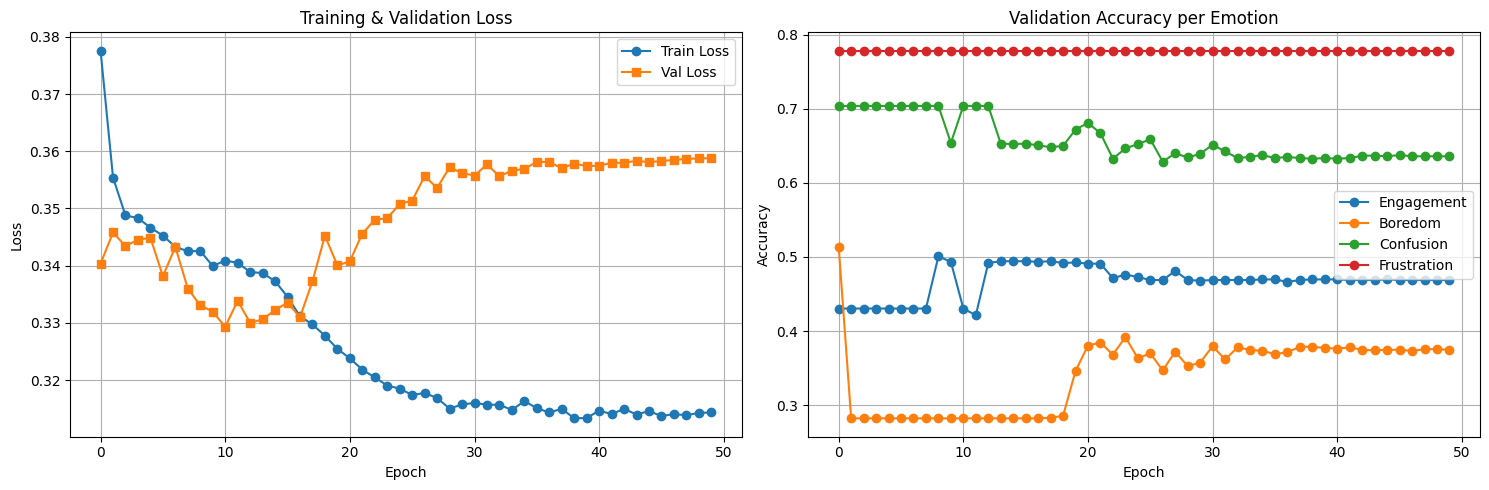

✅ Training curves saved to 'training_curves.png'


In [50]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy curves per emotion
for emotion, accuracies in history['val_accuracy'].items():
    axes[1].plot(accuracies, label=emotion, marker='o')

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy per Emotion')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved to 'training_curves.png'")

## 🧪 **10. Inference Functions**

In [51]:
def predict_from_sequence(model, sequence, device='cuda'):
    """
    Run inference on a single embedding sequence.
    
    Args:
        model: Trained MultiEmotionOrdinalModel
        sequence: numpy array (T, 768) or tensor
        device: Device
        
    Returns:
        predictions: dict with emotion predictions {0, 1, 2, 3}
    """
    model.eval()
    
    # Convert to tensor if needed
    if isinstance(sequence, np.ndarray):
        sequence = torch.tensor(sequence, dtype=torch.float32)
    
    # Add batch dimension
    sequence = sequence.unsqueeze(0).to(device)  # (1, T, 768)
    
    # Inference
    with torch.no_grad():
        logits_list = model(sequence)  # List of 4 tensors, each (1, 3)
    
    # Convert logits to predictions
    emotion_names = ['engagement', 'boredom', 'confusion', 'frustration']
    predictions = {}
    
    for emotion_idx, emotion_name in enumerate(emotion_names):
        emotion_logits = logits_list[emotion_idx]  # (1, 3)
        pred_class = predict_from_ordinal_logits(emotion_logits).item()
        predictions[emotion_name] = pred_class
    
    return predictions


def predict_from_embedding_file(model, embedding_path, device='cuda'):
    """
    Run inference on a saved embedding file.
    
    Args:
        model: Trained MultiEmotionOrdinalModel
        embedding_path: Path to .npy file
        device: Device
        
    Returns:
        predictions: dict with emotion predictions
    """
    embeddings = np.load(embedding_path)
    predictions = predict_from_sequence(model, embeddings, device)
    return predictions


print("✅ Inference functions defined")

✅ Inference functions defined


## 🧪 **11. Test Inference**

PREDICTED VS ACTUAL EVALUATION

✅ Best model loaded
   Val Loss: 0.3293
   Val Accuracies (Exact): [0.43044189852700493, 0.2823240589198036, 0.7037643207855974, 0.7782324058919804]
   Val Accuracies (±1): [0.9950900163666121, 0.9795417348608838, 0.9165302782324058, 0.936988543371522]

📊 Running predictions on validation set...


Predicting: 100%|██████████| 39/39 [00:01<00:00, 28.72it/s]



SAMPLE PREDICTIONS VS ACTUAL

📹 Video: 4140810210
Emotion         Actual     Predicted  Exact    ±1
------------------------------------------------------------
Engagement      1          2          ❌        ✅
Boredom         2          1          ❌        ✅
Confusion       0          0          ✅        ✅
Frustration     0          0          ✅        ✅

📹 Video: 1100012065
Emotion         Actual     Predicted  Exact    ±1
------------------------------------------------------------
Engagement      3          2          ❌        ✅
Boredom         0          1          ❌        ✅
Confusion       1          0          ❌        ✅
Frustration     1          0          ❌        ✅

📹 Video: 1100071014
Emotion         Actual     Predicted  Exact    ±1
------------------------------------------------------------
Engagement      3          2          ❌        ✅
Boredom         0          1          ❌        ✅
Confusion       0          0          ✅        ✅
Frustration     0          0       

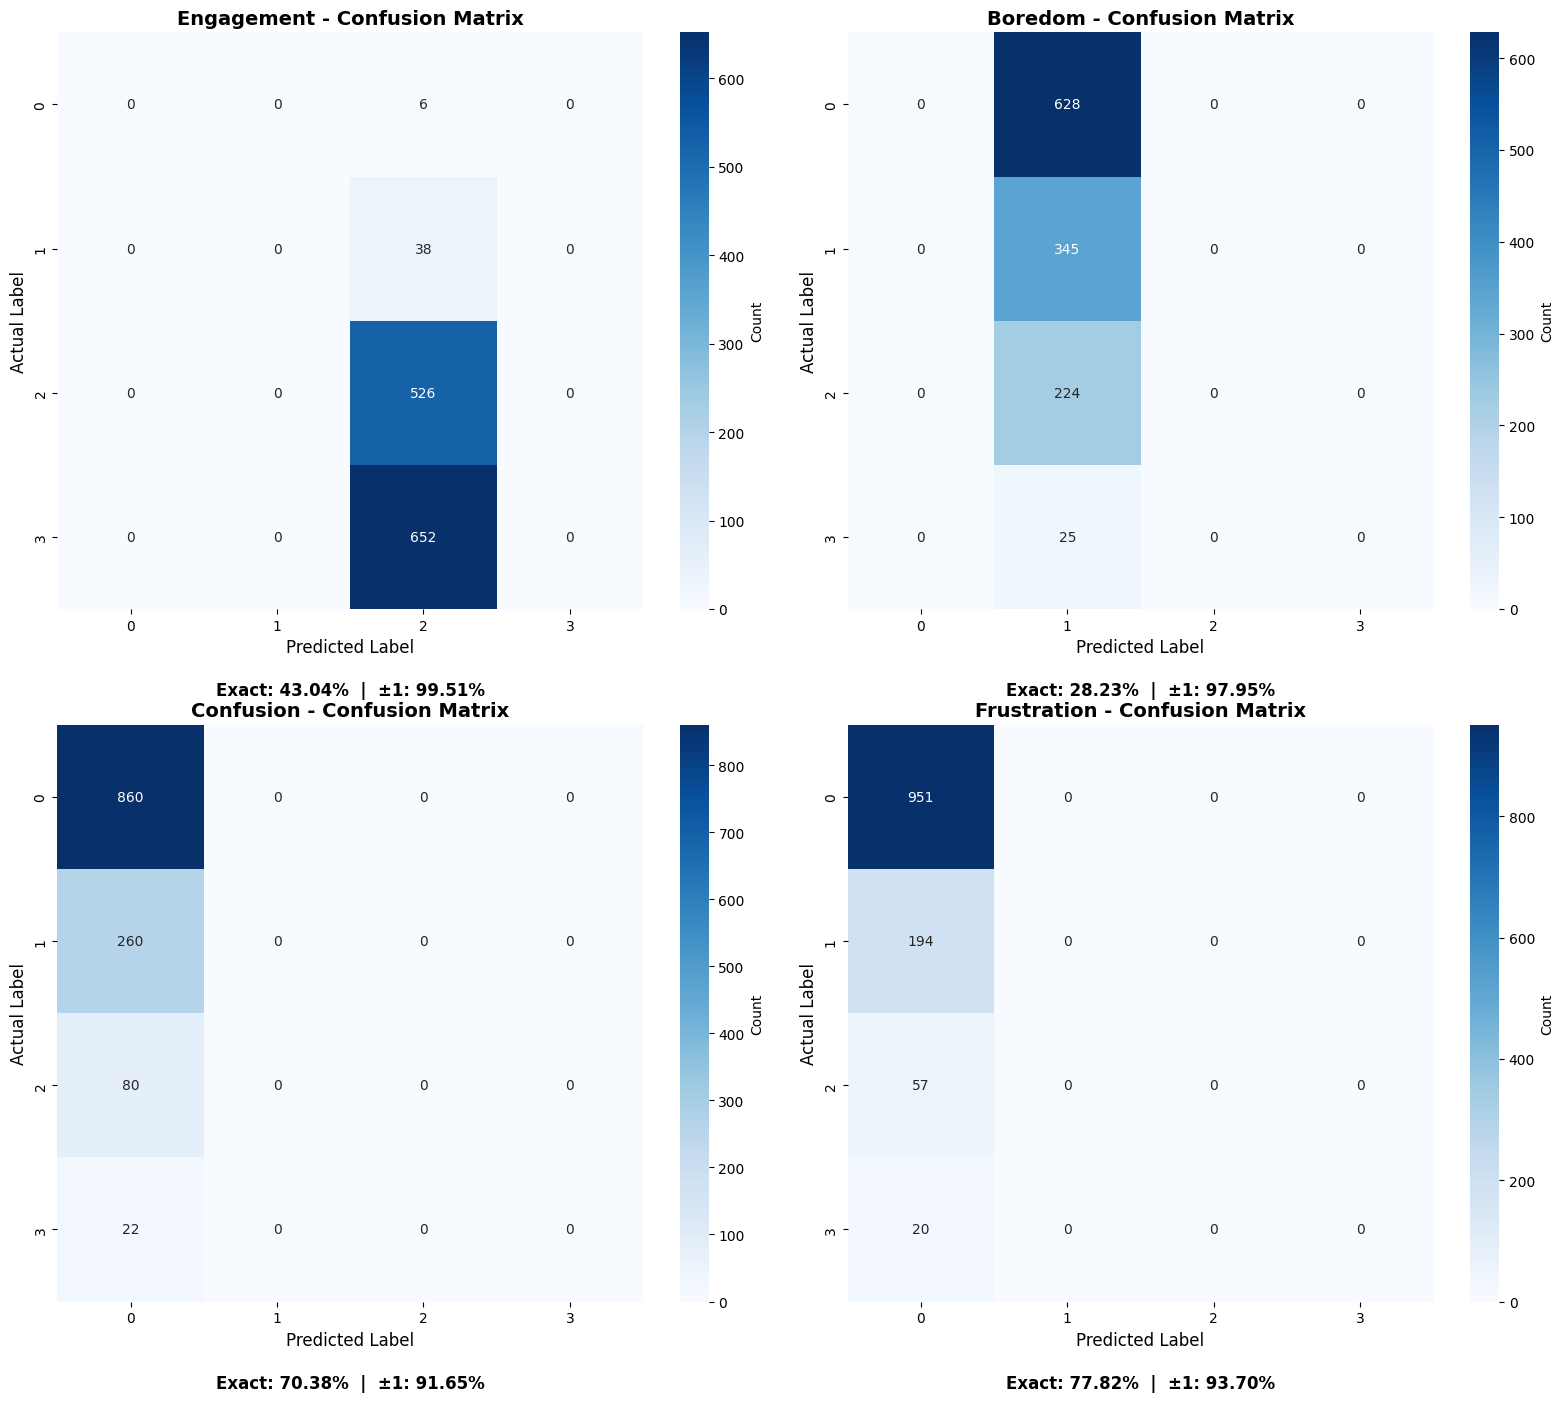


✅ Confusion matrices saved to 'confusion_matrices.png'

DETAILED CLASSIFICATION REPORTS

ENGAGEMENT
              precision    recall  f1-score   support

     Level 0       0.00      0.00      0.00         6
     Level 1       0.00      0.00      0.00        38
     Level 2       0.43      1.00      0.60       526
     Level 3       0.00      0.00      0.00       652

    accuracy                           0.43      1222
   macro avg       0.11      0.25      0.15      1222
weighted avg       0.19      0.43      0.26      1222


BOREDOM
              precision    recall  f1-score   support

     Level 0       0.00      0.00      0.00       628
     Level 1       0.28      1.00      0.44       345
     Level 2       0.00      0.00      0.00       224
     Level 3       0.00      0.00      0.00        25

    accuracy                           0.28      1222
   macro avg       0.07      0.25      0.11      1222
weighted avg       0.08      0.28      0.12      1222


CONFUSION
         

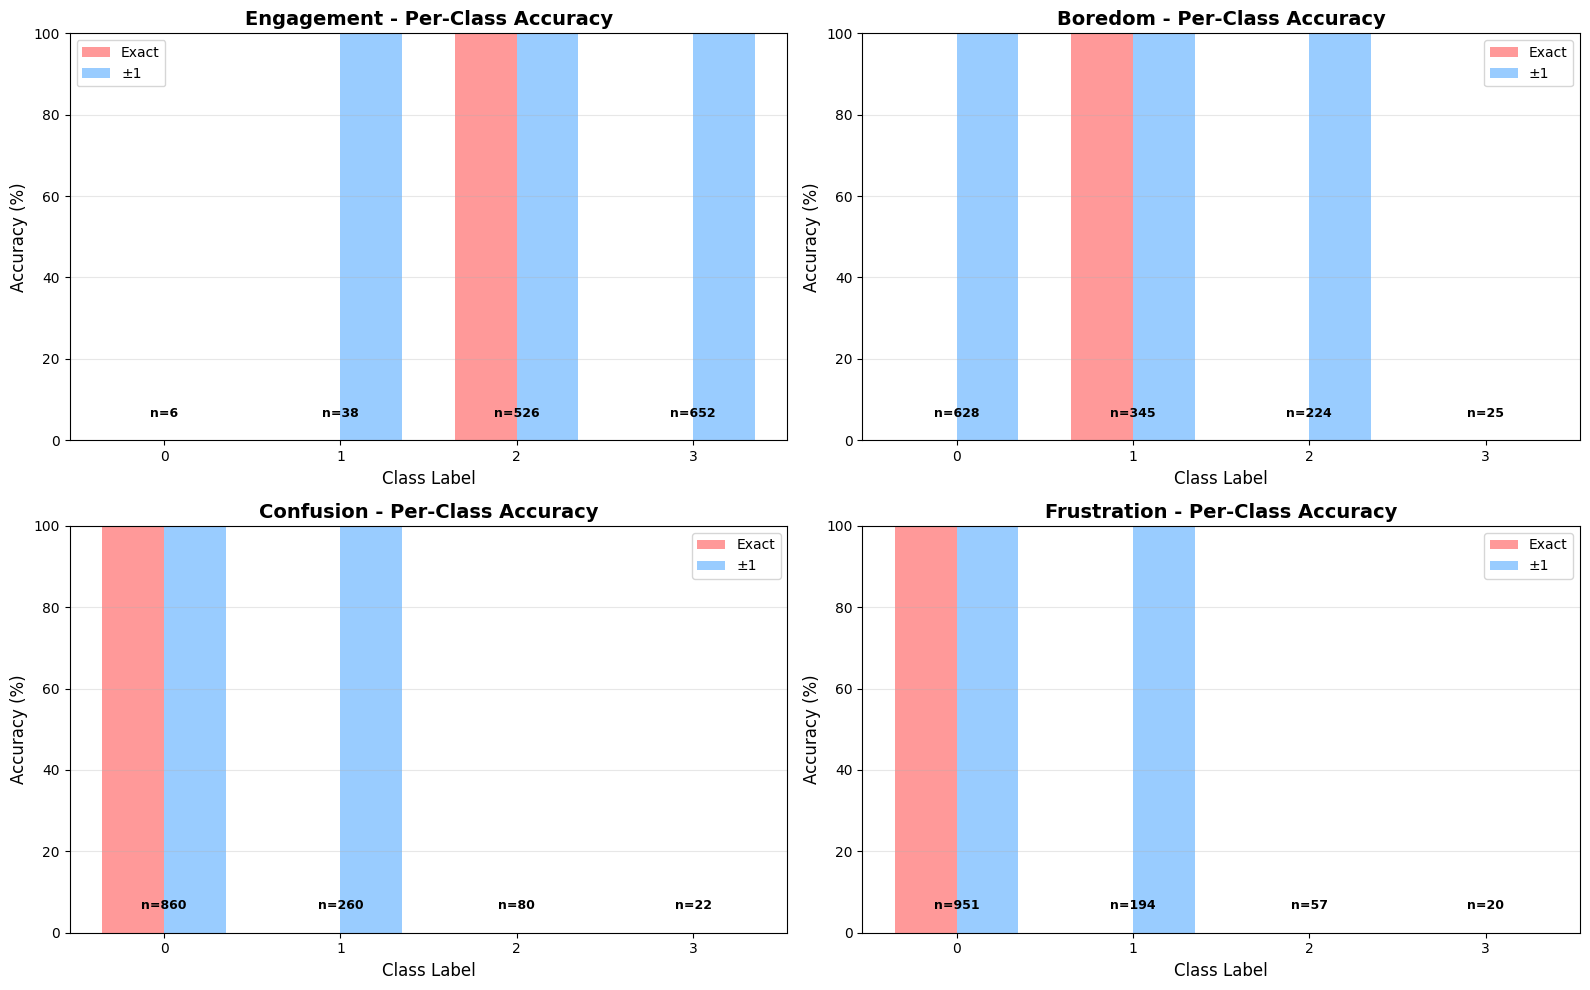


✅ Per-class accuracy saved to 'per_class_accuracy.png'

ERROR DISTRIBUTION ANALYSIS


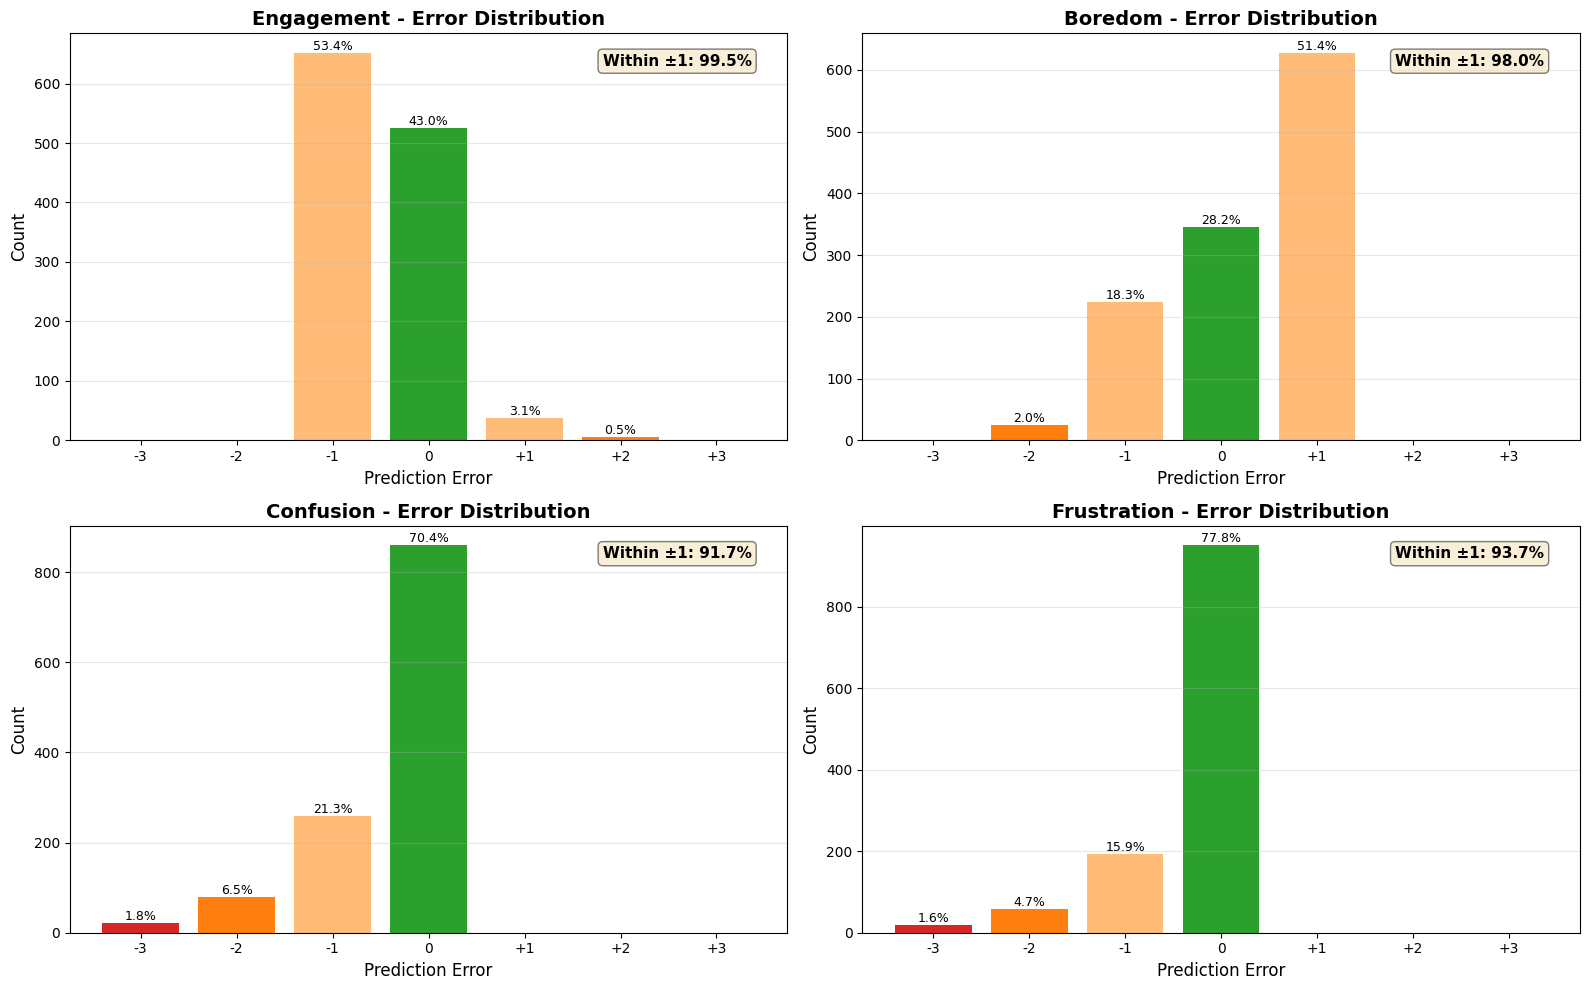


✅ Error distribution saved to 'error_distribution.png'

OVERALL STATISTICS

    Emotion Exact Acc (%) ±1 Acc (%)   MAE                                            Actual [0,1,2,3]                                     Predicted [0,1,2,3]
 Engagement        43.04%     99.51% 0.574   [np.int64(6), np.int64(38), np.int64(526), np.int64(652)] [np.int64(0), np.int64(0), np.int64(1222), np.int64(0)]
    Boredom        28.23%     97.95% 0.738 [np.int64(628), np.int64(345), np.int64(224), np.int64(25)] [np.int64(0), np.int64(1222), np.int64(0), np.int64(0)]
  Confusion        70.38%     91.65% 0.398  [np.int64(860), np.int64(260), np.int64(80), np.int64(22)] [np.int64(1222), np.int64(0), np.int64(0), np.int64(0)]
Frustration        77.82%     93.70% 0.301  [np.int64(951), np.int64(194), np.int64(57), np.int64(20)] [np.int64(1222), np.int64(0), np.int64(0), np.int64(0)]

AVERAGE EXACT ACCURACY:  54.87%
AVERAGE ±1 ACCURACY:     95.70%
IMPROVEMENT WITH ±1:     +40.83%

✅ Detailed results saved to '

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

# ============================================================
# PREDICTED VS ACTUAL - Comprehensive Evaluation with ±1 Accuracy
# ============================================================

print("="*60)
print("PREDICTED VS ACTUAL EVALUATION")
print("="*60)

# Load best model
checkpoint = torch.load('best_ordinal_model.pth', map_location=device)
ordinal_model.load_state_dict(checkpoint['model_state_dict'])
ordinal_model.eval()

print("\n✅ Best model loaded")
print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
print(f"   Val Accuracies (Exact): {checkpoint['val_accuracies']}")
if 'val_accuracies_pm1' in checkpoint:
    print(f"   Val Accuracies (±1): {checkpoint['val_accuracies_pm1']}")

# ============================================================
# Collect predictions for entire validation set
# ============================================================
emotion_names = ['Engagement', 'Boredom', 'Confusion', 'Frustration']
all_predictions = {emotion: [] for emotion in emotion_names}
all_actuals = {emotion: [] for emotion in emotion_names}

print("\n📊 Running predictions on validation set...")

with torch.no_grad():
    for sequences, labels in tqdm(val_loader, desc="Predicting"):
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Get predictions
        logits_list = ordinal_model(sequences)
        
        # Convert to class predictions for each emotion
        for emotion_idx in range(4):
            emotion_logits = logits_list[emotion_idx]
            predictions = predict_from_ordinal_logits(emotion_logits)
            
            all_predictions[emotion_names[emotion_idx]].extend(predictions.cpu().numpy())
            all_actuals[emotion_names[emotion_idx]].extend(labels[:, emotion_idx].cpu().numpy())

# Convert to numpy arrays for easier processing
for emotion in emotion_names:
    all_predictions[emotion] = np.array(all_predictions[emotion])
    all_actuals[emotion] = np.array(all_actuals[emotion])

# ============================================================
# Helper Function: ±1 Accuracy
# ============================================================
def calculate_pm1_accuracy(actuals, predictions):
    """Calculate ±1 accuracy (off-by-one tolerance)."""
    actuals = np.array(actuals)
    predictions = np.array(predictions)
    within_one = np.abs(actuals - predictions) <= 1
    return within_one.mean() * 100

# ============================================================
# Display Results for Random Samples
# ============================================================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS VS ACTUAL")
print("="*60)

num_samples = min(10, len(val_dataset))
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

for idx in sample_indices:
    item = val_dataset.metadata[idx]
    video_id = item['video_id']
    
    # Get actual labels
    actual = {
        'Engagement': item['engagement'],
        'Boredom': item['boredom'],
        'Confusion': item['confusion'],
        'Frustration': item['frustration']
    }
    
    # Get predictions
    embeddings = np.load(item['embedding_path'])
    predictions = predict_from_sequence(ordinal_model, embeddings, device)
    
    # Display
    print(f"\n📹 Video: {video_id}")
    print(f"{'Emotion':<15} {'Actual':<10} {'Predicted':<10} {'Exact':<8} {'±1'}")
    print("-" * 60)
    
    for emotion in emotion_names:
        emotion_lower = emotion.lower()
        actual_val = actual[emotion]
        pred_val = predictions[emotion_lower]
        
        exact_match = "✅" if actual_val == pred_val else "❌"
        pm1_match = "✅" if abs(actual_val - pred_val) <= 1 else "❌"
        
        print(f"{emotion:<15} {actual_val:<10} {pred_val:<10} {exact_match:<8} {pm1_match}")

# ============================================================
# Confusion Matrices for Each Emotion
# ============================================================
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, emotion in enumerate(emotion_names):
    # Compute confusion matrix
    cm = confusion_matrix(
        all_actuals[emotion], 
        all_predictions[emotion],
        labels=[0, 1, 2, 3]
    )
    
    # Plot
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=[0, 1, 2, 3],
        yticklabels=[0, 1, 2, 3],
        ax=axes[idx],
        cbar_kws={'label': 'Count'}
    )
    
    axes[idx].set_title(f'{emotion} - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=12)
    axes[idx].set_ylabel('Actual Label', fontsize=12)
    
    # Calculate exact and ±1 accuracy
    exact_accuracy = (all_predictions[emotion] == all_actuals[emotion]).mean() * 100
    pm1_accuracy = calculate_pm1_accuracy(all_actuals[emotion], all_predictions[emotion])
    
    axes[idx].text(
        0.5, -0.15, 
        f'Exact: {exact_accuracy:.2f}%  |  ±1: {pm1_accuracy:.2f}%',
        transform=axes[idx].transAxes,
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrices saved to 'confusion_matrices.png'")

# ============================================================
# Classification Reports
# ============================================================
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

for emotion in emotion_names:
    print(f"\n{'='*60}")
    print(f"{emotion.upper()}")
    print("="*60)
    
    report = classification_report(
        all_actuals[emotion],
        all_predictions[emotion],
        labels=[0, 1, 2, 3],
        target_names=['Level 0', 'Level 1', 'Level 2', 'Level 3'],
        zero_division=0
    )
    print(report)

# ============================================================
# Per-Class Accuracy Visualization (Exact + ±1)
# ============================================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY (EXACT AND ±1)")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, emotion in enumerate(emotion_names):
    # Calculate per-class exact and ±1 accuracy
    exact_accuracies = []
    pm1_accuracies = []
    class_counts = []
    
    actuals_array = all_actuals[emotion]
    predictions_array = all_predictions[emotion]
    
    for class_label in [0, 1, 2, 3]:
        mask = actuals_array == class_label
        if mask.sum() > 0:
            # Exact accuracy
            exact_correct = (predictions_array[mask] == class_label).sum()
            exact_acc = (exact_correct / mask.sum()) * 100
            exact_accuracies.append(exact_acc)
            
            # ±1 accuracy
            pm1_correct = (np.abs(predictions_array[mask] - class_label) <= 1).sum()
            pm1_acc = (pm1_correct / mask.sum()) * 100
            pm1_accuracies.append(pm1_acc)
            
            class_counts.append(mask.sum())
        else:
            exact_accuracies.append(0)
            pm1_accuracies.append(0)
            class_counts.append(0)
    
    # Plot
    x = np.arange(4)
    width = 0.35
    
    bars1 = axes[idx].bar(x - width/2, exact_accuracies, width, label='Exact', color='#ff9999')
    bars2 = axes[idx].bar(x + width/2, pm1_accuracies, width, label='±1', color='#99ccff')
    
    axes[idx].set_xlabel('Class Label', fontsize=12)
    axes[idx].set_ylabel('Accuracy (%)', fontsize=12)
    axes[idx].set_title(f'{emotion} - Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([0, 1, 2, 3])
    axes[idx].set_ylim([0, 100])
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, count in enumerate(class_counts):
        axes[idx].text(
            i, 5,
            f'n={count}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Per-class accuracy saved to 'per_class_accuracy.png'")

# ============================================================
# Error Distribution Analysis
# ============================================================
print("\n" + "="*60)
print("ERROR DISTRIBUTION ANALYSIS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, emotion in enumerate(emotion_names):
    actuals = all_actuals[emotion]
    predictions = all_predictions[emotion]
    
    # Calculate errors
    errors = predictions - actuals
    
    # Count error distribution
    error_counts = {
        '-3': np.sum(errors == -3),
        '-2': np.sum(errors == -2),
        '-1': np.sum(errors == -1),
        '0': np.sum(errors == 0),
        '+1': np.sum(errors == 1),
        '+2': np.sum(errors == 2),
        '+3': np.sum(errors == 3),
    }
    
    # Plot
    colors = ['#d62728', '#ff7f0e', '#ffbb78', '#2ca02c', '#ffbb78', '#ff7f0e', '#d62728']
    bars = axes[idx].bar(error_counts.keys(), error_counts.values(), color=colors)
    
    axes[idx].set_xlabel('Prediction Error', fontsize=12)
    axes[idx].set_ylabel('Count', fontsize=12)
    axes[idx].set_title(f'{emotion} - Error Distribution', fontsize=14, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = len(actuals)
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            percentage = (height / total) * 100
            axes[idx].text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{percentage:.1f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )
    
    # Add summary
    within_1 = np.sum(np.abs(errors) <= 1)
    within_1_pct = (within_1 / total) * 100
    axes[idx].text(
        0.95, 0.95,
        f'Within ±1: {within_1_pct:.1f}%',
        transform=axes[idx].transAxes,
        ha='right',
        va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=11,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Error distribution saved to 'error_distribution.png'")

# ============================================================
# Overall Statistics Summary (with ±1 accuracy)
# ============================================================
print("\n" + "="*60)
print("OVERALL STATISTICS")
print("="*60)

summary_data = []
for emotion in emotion_names:
    actuals = all_actuals[emotion]
    predictions = all_predictions[emotion]
    
    # Exact accuracy
    exact_accuracy = (predictions == actuals).mean() * 100
    
    # ±1 accuracy
    pm1_accuracy = calculate_pm1_accuracy(actuals, predictions)
    
    # Mean Absolute Error
    mae = np.abs(predictions - actuals).mean()
    
    # Distribution
    actual_dist = [np.sum(actuals == i) for i in range(4)]
    pred_dist = [np.sum(predictions == i) for i in range(4)]
    
    summary_data.append({
        'Emotion': emotion,
        'Exact Acc (%)': f'{exact_accuracy:.2f}%',
        '±1 Acc (%)': f'{pm1_accuracy:.2f}%',
        'MAE': f'{mae:.3f}',
        'Actual [0,1,2,3]': str(actual_dist),
        'Predicted [0,1,2,3]': str(pred_dist)
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Average across all emotions
avg_exact_accuracy = np.mean([
    (all_predictions[emotion] == all_actuals[emotion]).mean() 
    for emotion in emotion_names
]) * 100

avg_pm1_accuracy = np.mean([
    calculate_pm1_accuracy(all_actuals[emotion], all_predictions[emotion])
    for emotion in emotion_names
])

print(f"\n{'='*60}")
print(f"AVERAGE EXACT ACCURACY:  {avg_exact_accuracy:.2f}%")
print(f"AVERAGE ±1 ACCURACY:     {avg_pm1_accuracy:.2f}%")
print(f"IMPROVEMENT WITH ±1:     +{avg_pm1_accuracy - avg_exact_accuracy:.2f}%")
print("="*60)

# ============================================================
# Save Results to CSV (with ±1 accuracy)
# ============================================================
results_csv = []
for i in range(len(val_dataset)):
    item = val_dataset.metadata[i]
    
    row = {
        'video_id': item['video_id'],
        
        'actual_engagement': int(all_actuals['Engagement'][i]),
        'pred_engagement': int(all_predictions['Engagement'][i]),
        'engagement_exact_match': int(all_actuals['Engagement'][i] == all_predictions['Engagement'][i]),
        'engagement_pm1_match': int(abs(all_actuals['Engagement'][i] - all_predictions['Engagement'][i]) <= 1),
        
        'actual_boredom': int(all_actuals['Boredom'][i]),
        'pred_boredom': int(all_predictions['Boredom'][i]),
        'boredom_exact_match': int(all_actuals['Boredom'][i] == all_predictions['Boredom'][i]),
        'boredom_pm1_match': int(abs(all_actuals['Boredom'][i] - all_predictions['Boredom'][i]) <= 1),
        
        'actual_confusion': int(all_actuals['Confusion'][i]),
        'pred_confusion': int(all_predictions['Confusion'][i]),
        'confusion_exact_match': int(all_actuals['Confusion'][i] == all_predictions['Confusion'][i]),
        'confusion_pm1_match': int(abs(all_actuals['Confusion'][i] - all_predictions['Confusion'][i]) <= 1),
        
        'actual_frustration': int(all_actuals['Frustration'][i]),
        'pred_frustration': int(all_predictions['Frustration'][i]),
        'frustration_exact_match': int(all_actuals['Frustration'][i] == all_predictions['Frustration'][i]),
        'frustration_pm1_match': int(abs(all_actuals['Frustration'][i] - all_predictions['Frustration'][i]) <= 1),
    }
    results_csv.append(row)

results_df = pd.DataFrame(results_csv)
results_df.to_csv('predictions_vs_actual.csv', index=False)

print(f"\n✅ Detailed results saved to 'predictions_vs_actual.csv'")
print(f"✅ Total samples evaluated: {len(results_df)}")

# ============================================================
# Final Summary
# ============================================================
print("\n" + "🎉"*30)
print("EVALUATION COMPLETE!")
print("🎉"*30)

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Average Exact Accuracy:  {avg_exact_accuracy:.2f}%")
print(f"Average ±1 Accuracy:     {avg_pm1_accuracy:.2f}%")
print(f"\nFiles generated:")
print("  📊 confusion_matrices.png")
print("  📊 per_class_accuracy.png")
print("  📊 error_distribution.png")
print("  📄 predictions_vs_actual.csv")
print("="*60)

In [82]:
# Load best model
checkpoint = torch.load('best_ordinal_model.pth', map_location=device)
ordinal_model.load_state_dict(checkpoint['model_state_dict'])

print("✅ Best model loaded")
print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
print(f"   Val Accuracies: {checkpoint['val_accuracies']}")

# Test on random samples
print("\n" + "="*60)
print("TESTING INFERENCE")
print("="*60)

embedding_files = list(Path(EMBEDDING_DIR).glob('*.npy'))
test_samples = np.random.choice(embedding_files, min(5, len(embedding_files)), replace=False)

for test_file in test_samples:
    predictions = predict_from_embedding_file(ordinal_model, test_file, device)
    
    print(f"\nFile: {test_file.name}")
    for emotion, value in predictions.items():
        print(f"  {emotion.capitalize()}: {value} (0-3)")

✅ Best model loaded
   Val Loss: 0.3261
   Val Accuracies: [0.4909983633387889, 0.5368248772504092, 0.6620294599018003, 0.7782324058919804]

TESTING INFERENCE

File: 4000181015.npy
  Engagement: 2 (0-3)
  Boredom: 2 (0-3)
  Confusion: 0 (0-3)
  Frustration: 0 (0-3)

File: 3100642034.npy
  Engagement: 2 (0-3)
  Boredom: 1 (0-3)
  Confusion: 0 (0-3)
  Frustration: 0 (0-3)

File: 2100612002.npy
  Engagement: 2 (0-3)
  Boredom: 2 (0-3)
  Confusion: 0 (0-3)
  Frustration: 0 (0-3)

File: 3100741057.npy
  Engagement: 2 (0-3)
  Boredom: 0 (0-3)
  Confusion: 0 (0-3)
  Frustration: 0 (0-3)

File: 2100572009.npy
  Engagement: 2 (0-3)
  Boredom: 0 (0-3)
  Confusion: 0 (0-3)
  Frustration: 0 (0-3)


## 💾 **12. Save Complete Model**

In [ ]:
def save_complete_model(model, config, save_path='edusense_ordinal_complete.pth'):
    """
    Save model with full config for easy loading.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config
    }, save_path)
    print(f"✅ Complete model saved to: {save_path}")


def load_complete_model(load_path='edusense_ordinal_complete.pth', device='cuda'):
    """
    Load model with automatic config restoration.
    """
    checkpoint = torch.load(load_path, map_location=device)
    
    # Recreate model
    model = MultiEmotionOrdinalModel(**checkpoint['config']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Model loaded from: {load_path}")
    return model


# Save current model
save_complete_model(ordinal_model, MODEL_CONFIG, 'edusense_ordinal_final.pth')

---
# 🎓 **Summary**
---

## ✅ What We Built

### **Multi-Task Ordinal Classification Model**
- **Input:** Pre-extracted embeddings (T, 768)
- **Architecture:** LSTM → KAN → 4 Ordinal Heads
- **Output:** 4 emotion predictions (Engagement, Boredom, Confusion, Frustration)
- **Loss:** CORAL (Consistent Rank Logits)
- **Classes:** Each emotion predicted as {0, 1, 2, 3}

## 🔑 Key Features

1. **Ordinal Classification**
   - Respects ordered nature of labels (3 > 2 > 1 > 0)
   - CORAL loss treats as K-1 binary problems
   - Better than regression or standard classification

2. **Multi-Task Learning**
   - Shared LSTM + KAN representation
   - Task-specific ordinal heads
   - Joint optimization across emotions

3. **Production-Ready**
   - Subject-wise data split (no leakage)
   - Modular, clean code
   - Easy inference pipeline
   - Model checkpointing

## 📊 Performance Tracking

- Training loss
- Validation loss
- Per-emotion accuracy
- Average accuracy across emotions

## 🚀 Next Steps

1. Fine-tune hyperparameters
2. Experiment with different KAN architectures
3. Add attention mechanisms
4. Deploy for real-time inference

---

**King Khalid University**  
**EduSense Graduation Project 2025**  
**CORAL Ordinal Classification ✅**